# Calculate song information contained in pairs of MA neurons

Because each neuron maps song to a single real number, $r_i = f_i[s(t < t')]$, the mutual info $MI[r_i, s]$ is given simply by the response entropy $H[r_i]$, since

$$MI[r_i, s] = H[r_i] - E_s[H[r_i|s]] = H[r_i]$$

since $H[r_i|s] = H[f_i(s)|s] = 0$, i.e. there is no noise, so each song maps to exactly one neural response value.

In [1]:
%matplotlib inline
from itertools import product as cproduct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

from disp import set_plot


cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

In [2]:
# neural params
TAU_R = np.array([.1, .5, 1, 2, 5, 10, 30, 60, 120])
TAU_A = np.array([.1, .5, 1, 2, 5, 10, 30, 60, np.inf])
X_S = np.array([0, .5, 1])

tau_r_tau_a_x_s = np.array(list(cproduct(TAU_R, TAU_A, X_S)))

tau_rs = tau_r_tau_a_x_s[:, 0]
tau_as = tau_r_tau_a_x_s[:, 1]
x_ss = tau_r_tau_a_x_s[:, 2]
x_ps = 1 - x_ss  # pulse selectivity

nr = len(tau_rs)

In [3]:
# load all neural recordings
PFX_NRL = f'data/simple/mlv/ma_built/nrl_ctl/ma_built_nrl_shfl'

dfs_tr = [np.load(f'{PFX_NRL}_tr_{itr}.npy', allow_pickle=True)[0]['df'] for itr in ISTRAIN]

In [4]:
R_COLS = [f'R_{ir}' for ir in range(nr)]

# keep all neural activity
# frs = cc([np.array(df_tr[R_COLS]) for df_tr in dfs_tr])

# only keep neural activity after first song onset
it_song_starts = [np.nonzero(np.array(df_tr['Q']) == 0)[0][0] for df_tr in dfs_tr]
frs = cc([np.array(df_tr[R_COLS])[it_song_start:, :] for df_tr, it_song_start in zip(dfs_tr, it_song_starts)])

dfs_tr = None

In [5]:
nbin = 10
bins = np.linspace(0, 1, nbin+1)

ents = np.nan * np.zeros((nr, nr))

for inrn_0 in range(frs.shape[1]):
    sys.stdout.write('.')
    fr_0 = frs[:, inrn_0].copy()
    fr_0 /= fr_0.max()
    
    for inrn_1 in range(inrn_0, frs.shape[1]):
        fr_1 = frs[:, inrn_1].copy()
        fr_1 /= fr_1.max()
        
        cts_fr = np.histogram2d(fr_0, fr_1, bins=bins)[0]
        p_fr = cts_fr/cts_fr.sum()
        
        ent = stats.entropy(p_fr.flatten(), base=2)
        ents[inrn_0, inrn_1] = ent

...................................................................................................................................................................................................................................................

H = 6.245 (idxs = (1, 221))
X_S_0 = 0.5, TAU_R_0 = 0.1, TAU_A_0 = 0.1
X_S_1 = 1.0, TAU_R_1 = 120.0, TAU_A_1 = 0.5

H = 6.244 (idxs = (1, 218))
X_S_0 = 0.5, TAU_R_0 = 0.1, TAU_A_0 = 0.1
X_S_1 = 1.0, TAU_R_1 = 120.0, TAU_A_1 = 0.1

H = 6.244 (idxs = (1, 224))
X_S_0 = 0.5, TAU_R_0 = 0.1, TAU_A_0 = 0.1
X_S_1 = 1.0, TAU_R_1 = 120.0, TAU_A_1 = 1.0

H = 6.244 (idxs = (1, 227))
X_S_0 = 0.5, TAU_R_0 = 0.1, TAU_A_0 = 0.1
X_S_1 = 1.0, TAU_R_1 = 120.0, TAU_A_1 = 2.0

H = 6.241 (idxs = (1, 230))
X_S_0 = 0.5, TAU_R_0 = 0.1, TAU_A_0 = 0.1
X_S_1 = 1.0, TAU_R_1 = 120.0, TAU_A_1 = 5.0

H = 6.238 (idxs = (1, 233))
X_S_0 = 0.5, TAU_R_0 = 0.1, TAU_A_0 = 0.1
X_S_1 = 1.0, TAU_R_1 = 120.0, TAU_A_1 = 10.0

H = 6.226 (idxs = (1, 236))
X_S_0 = 0.5, TAU_R_0 = 0.1, TAU_A_0 = 0.1
X_S_1 = 1.0, TAU_R_1 = 120.0, TAU_A_1 = 30.0

H = 6.218 (idxs = (1, 239))
X_S_0 = 0.5, TAU_R_0 = 0.1, TAU_A_0 = 0.1
X_S_1 = 1.0, TAU_R_1 = 120.0, TAU_A_1 = 60.0

H = 6.160 (idxs = (1, 217))
X_S_0 = 0.5, TAU_R_0 = 0.1, TAU_A_0 = 0.1
X_S_1 =

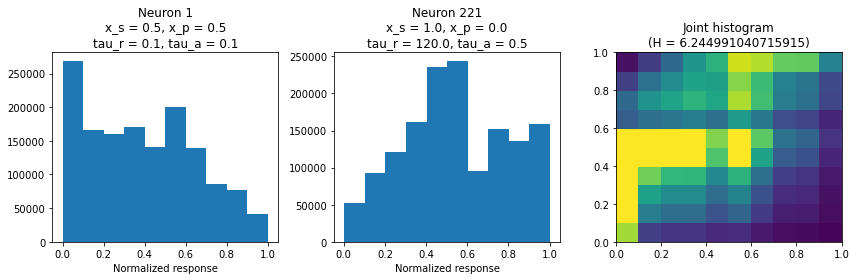

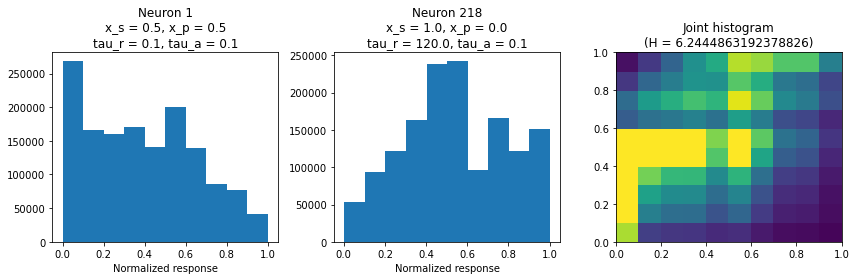

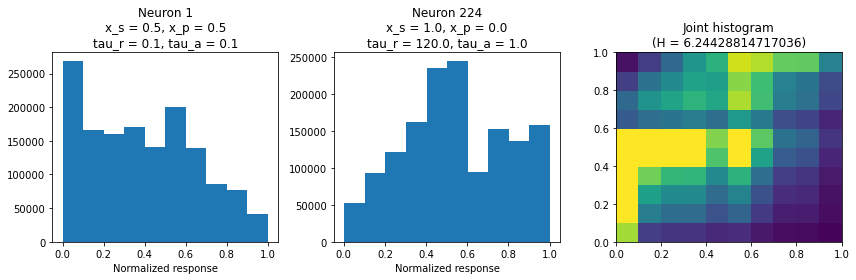

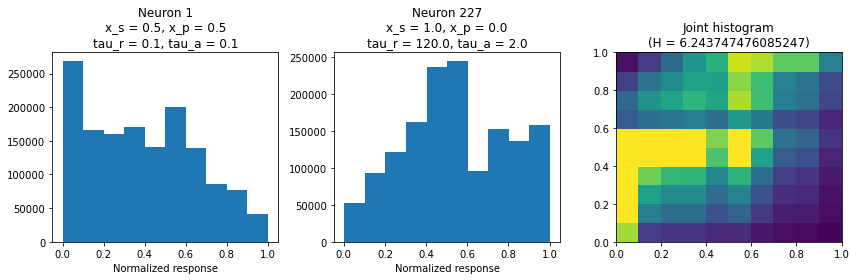

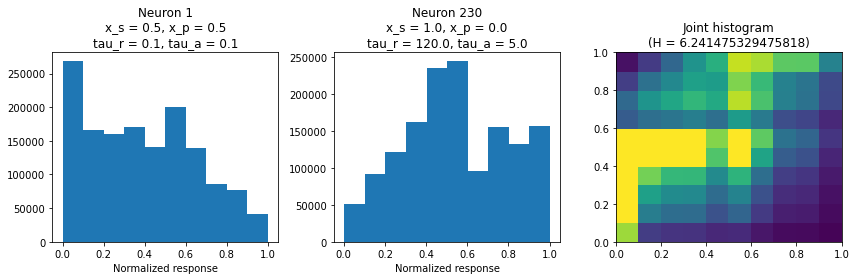

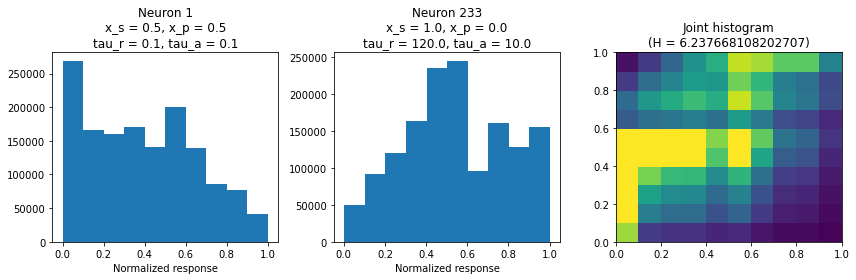

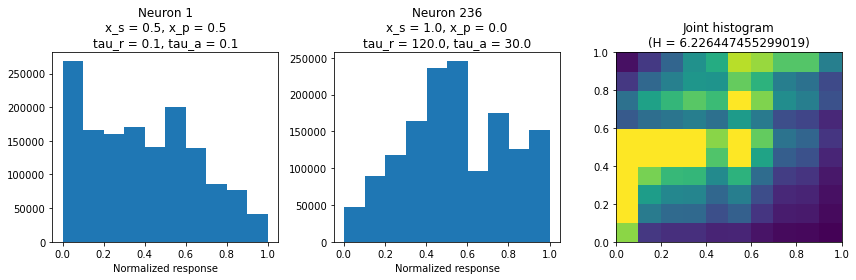

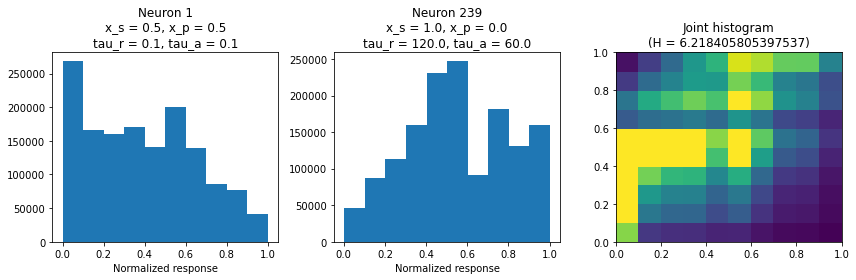

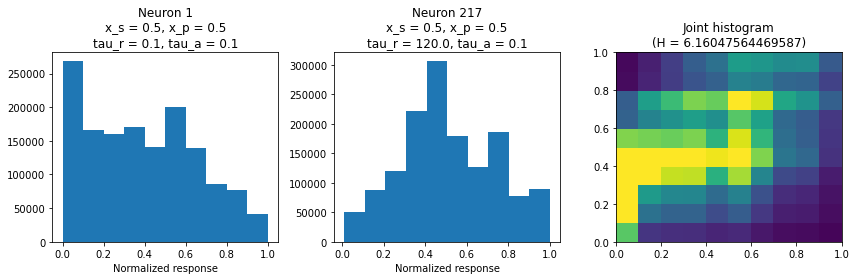

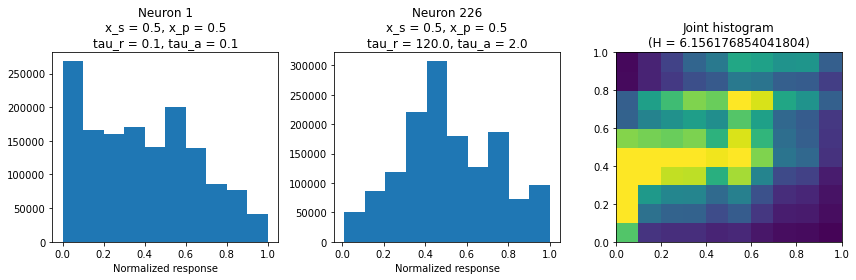

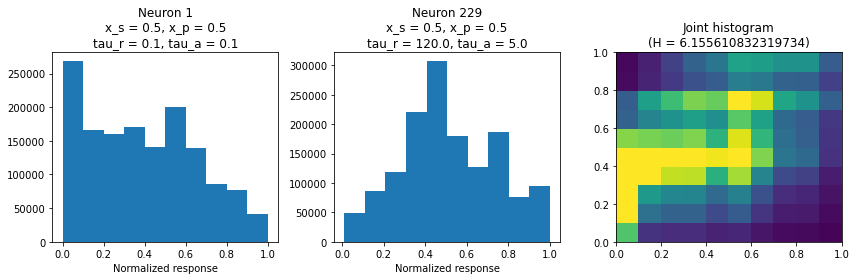

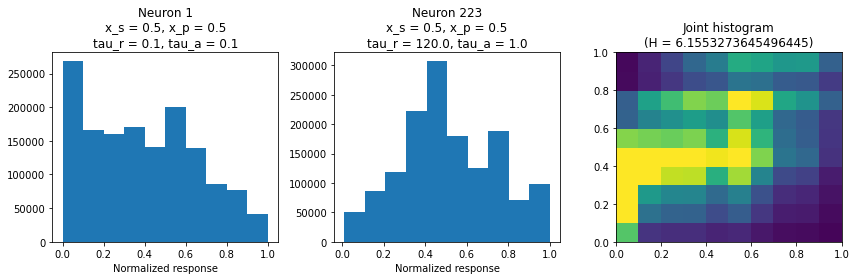

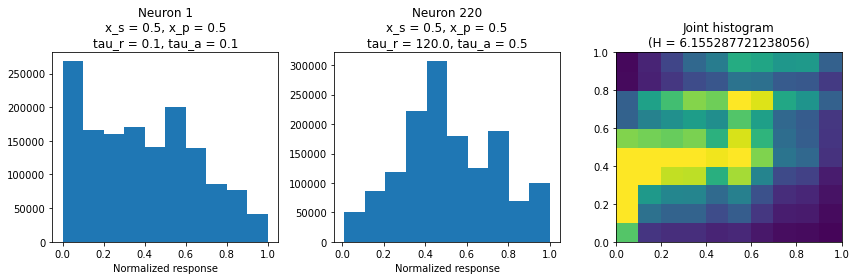

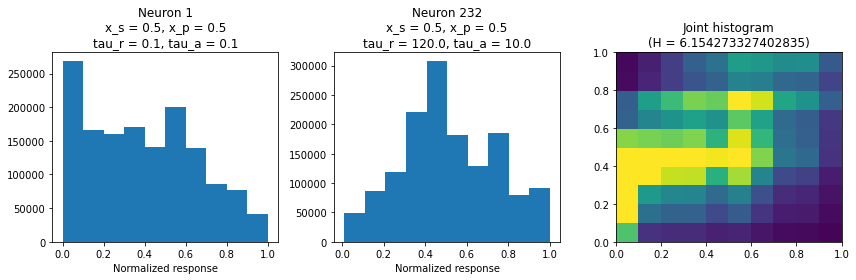

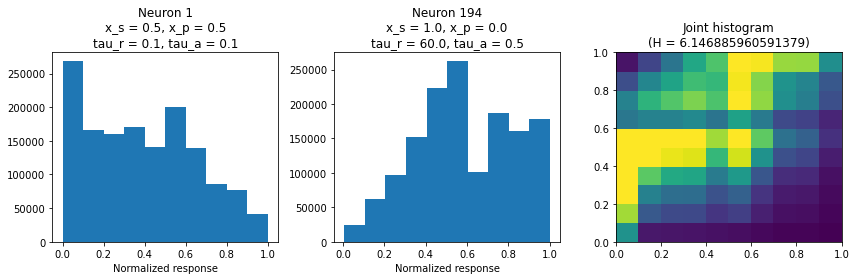

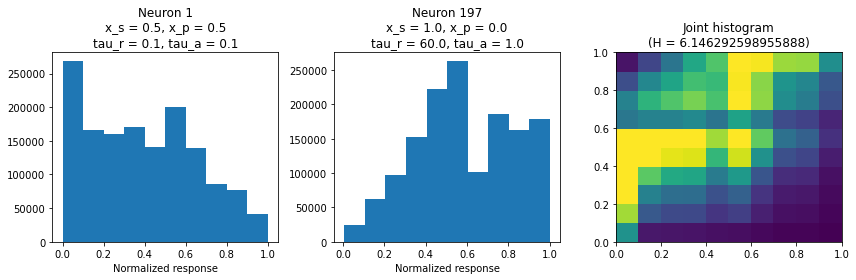

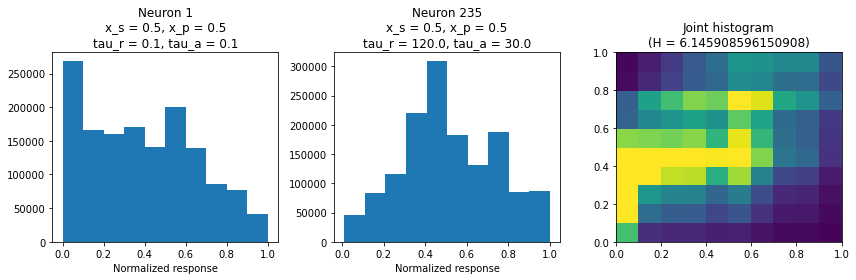

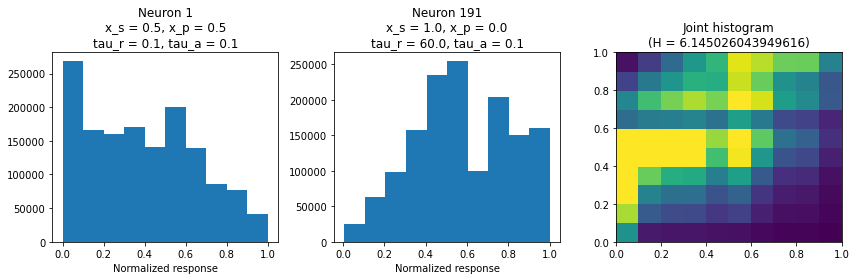

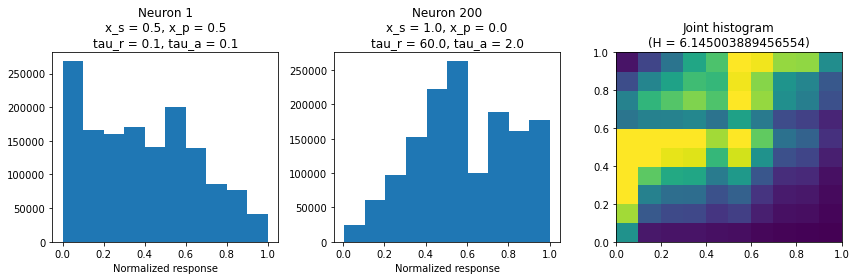

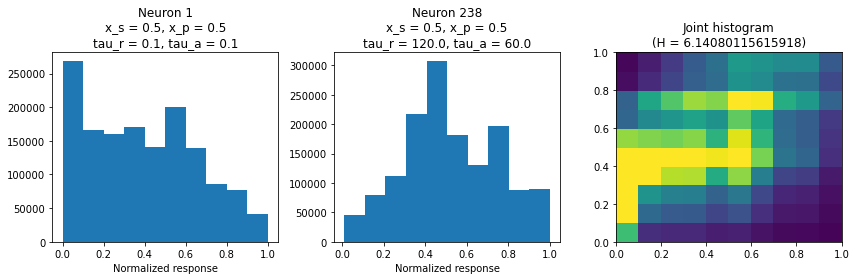

In [6]:
# print out best neuron pairs
npair = 20
ents[np.isnan(ents)] = -1
sort_idx = ents.flatten().argsort()[::-1]
# sort_idx = np.random.permutation(len(sort_idx))
inrns_0, inrns_1 = np.unravel_index(sort_idx, ents.shape)

for inrn_0, inrn_1 in zip(inrns_0[:npair], inrns_1[:npair]):
    print(f'H = {ents[inrn_0, inrn_1]:.3f} (idxs = {inrn_0, inrn_1})')
    print(f'X_S_0 = {x_ss[inrn_0]}, TAU_R_0 = {tau_rs[inrn_0]}, TAU_A_0 = {tau_as[inrn_0]}')
    print(f'X_S_1 = {x_ss[inrn_1]}, TAU_R_1 = {tau_rs[inrn_1]}, TAU_A_1 = {tau_as[inrn_1]}')
    print('')
    
    # plot individual and joint histograms
    fr_0 = frs[:, inrn_0].copy()
    fr_0 /= fr_0.max()
    fr_1 = frs[:, inrn_1].copy()
    fr_1 /= fr_1.max()
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
    axs[0].hist(fr_0)
    axs[0].set_xlabel('Normalized response')
    axs[0].set_title(f'Neuron {inrn_0}\nx_s = {x_ss[inrn_0]}, x_p = {x_ps[inrn_0]}\ntau_r = {tau_rs[inrn_0]}, tau_a = {tau_as[inrn_0]}')
    
    axs[1].hist(fr_1)
    axs[1].set_xlabel('Normalized response')
    axs[1].set_title(f'Neuron {inrn_1}\nx_s = {x_ss[inrn_1]}, x_p = {x_ps[inrn_1]}\ntau_r = {tau_rs[inrn_1]}, tau_a = {tau_as[inrn_1]}')
    
    axs[2].hist2d(fr_0, fr_1, bins=bins, density=True, vmin=0, vmax=2)
    axs[2].set_title(f'Joint histogram\n(H = {ents[inrn_0, inrn_1]})')